In [1]:
from glob import glob
from datetime import datetime, date
from os.path import join, basename, expanduser
import pickle
import numpy as np
import pandas as pd
import rioxarray as rxa
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from metloom.pointdata import SnotelPointData
from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)
lidar_dir = '/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar'
fig_dir = '/bsuhome/zacharykeskinen/uavsar/figures/lidar_sd_compare'

ModuleNotFoundError: No module named 'metloom'

In [ ]:
def get_name(fp):
    name = basename(fp)
    if '_SD_' in name:
        return datetime.strptime(name.split('_')[-2], '%Y%m%d')
    elif '-snowdepth' in name:
        return datetime.strptime(name.split('_')[0], '%Y%m%d')

def get_snow_depth_change(name, date1, date2):
    snotels = {'mores':"637:ID:SNTL", 'dry_creek':"978:ID:SNTL", 'banner':"312:ID:SNTL"}
    snotel_point = SnotelPointData(snotels[name], name + '_snotel')
    df = snotel_point.get_daily_data(
        date1, date2,
        [snotel_point.ALLOWED_VARIABLES.SNOWDEPTH]
    )
    if df['SNOWDEPTH_units'].iloc[0] == 'in':
        sd = df['SNOWDEPTH']*0.0254
        return sd.iloc[-1] - sd.iloc[0]
    else:
        print('Not in inches?')

def get_snotel_loc(name):
    snotels = {'mores':"637:ID:SNTL", 'dry_creek':"978:ID:SNTL", 'banner':"312:ID:SNTL"}
    snotel_point = SnotelPointData(snotels[name], name + '_snotel')
    df = snotel_point.get_daily_data(
        '2020-01-01', '2020-01-03',
        [snotel_point.ALLOWED_VARIABLES.SNOWDEPTH]
    )
    return df.geometry.iloc[0]

def clean_nps(arrs):
    idx = np.zeros_like(arrs[0], dtype = arrs[0].dtype)
    for arr in arrs:
        idx += arr

    for i in range(len(arrs)):
        arrs[i] = arrs[i][np.where(~np.isnan(idx))]
    return arrs

def clean_two_nps(arr1, arr2):
    buff = arr1
    arr1 = arr1[(~np.isnan(arr1)) & (~np.isnan(arr2))]
    arr2 = arr2[(~np.isnan(buff)) & (~np.isnan(arr2))]
    return arr1, arr2

def datarray_to_numpy(x, y):
    if type(x)== xr.core.dataarray.DataArray:
        x_dirty = x.values.ravel()
        y = y.values.ravel()
    else:
        x_dirty = x
    x = x_dirty[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    y = y[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    return x, y

def r2_value(x, y):
    x, y = datarray_to_numpy(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'slope: {slope}. intercept: {intercept}. r_value {r_value}. p value: {p_value}')
    return slope, intercept, r_value, p_value, x, y

def mann_test(x, y, xlabel = 'x', ylabel = 'y'):
    x, y = datarray_to_numpy(x,y)
    stat, p = mannwhitneyu(x, y)   
    print(f'Comparison of {xlabel} vs {ylabel} center has a p value of {p:.10f} of not being from same distribution with {len(x)} observations.')
    if p < 0.1:
        print(f'Median of {xlabel}: {np.median(x)} compared to median of {ylabel}: {np.median(y)}')

from math import cos, sin, asin, sqrt, radians
def calc_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

In [151]:
phase = rxa.open_rasterio(img['fp'])
phase = phase.rio.clip_box(*sd.rio.bounds())

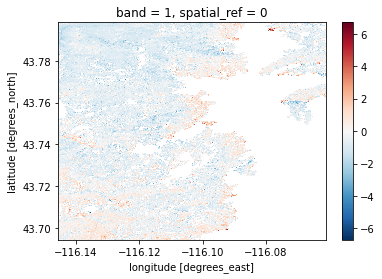

In [155]:
phase.plot()

mores
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/mores/SNEX20_QSI_SD_0.5M_USIDMC_20200209_20200209.tif
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


slope: 0.048251479133582076. intercept: 0.08578285853626272. r_value 0.2411241436284025. p value: 0.0


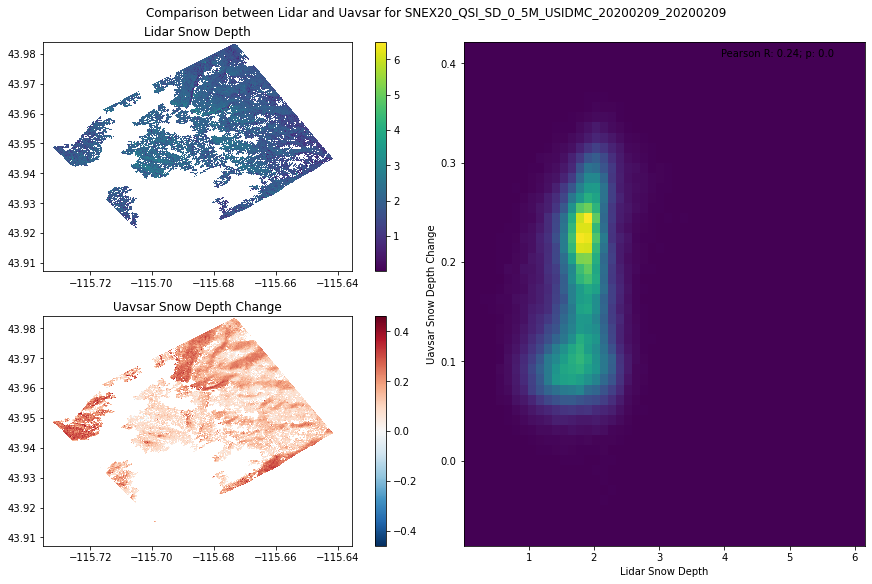

mores
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/mores/SNEX20_QSI_SD_0.5M_USIDMC_20210315_20210315.tif
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


slope: 0.010052817511770756. intercept: -0.16002300163565325. r_value 0.1361567131946755. p value: 0.0


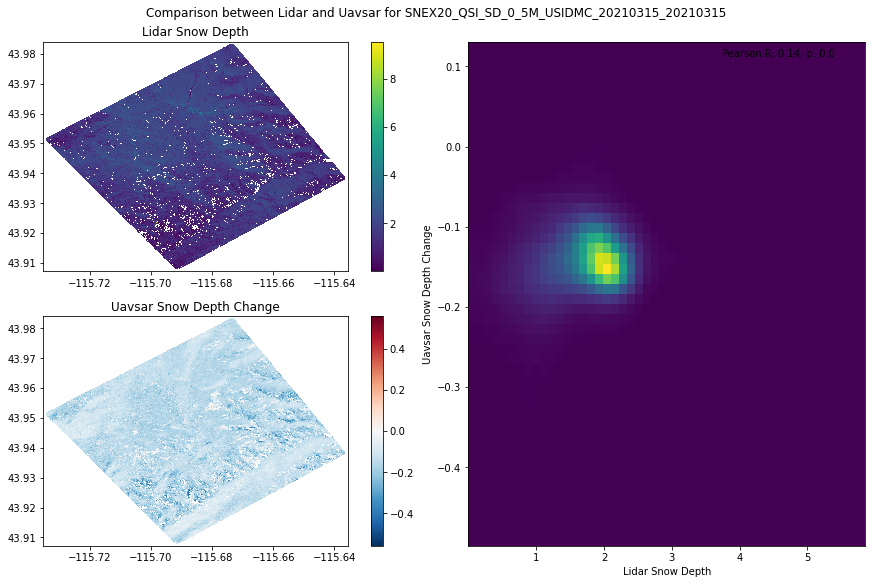

mores
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/mores/20210310_MCS-snowdepth.tif
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


slope: 0.03663354122834236. intercept: -0.2723360090822822. r_value 0.3201833785056071. p value: 0.0


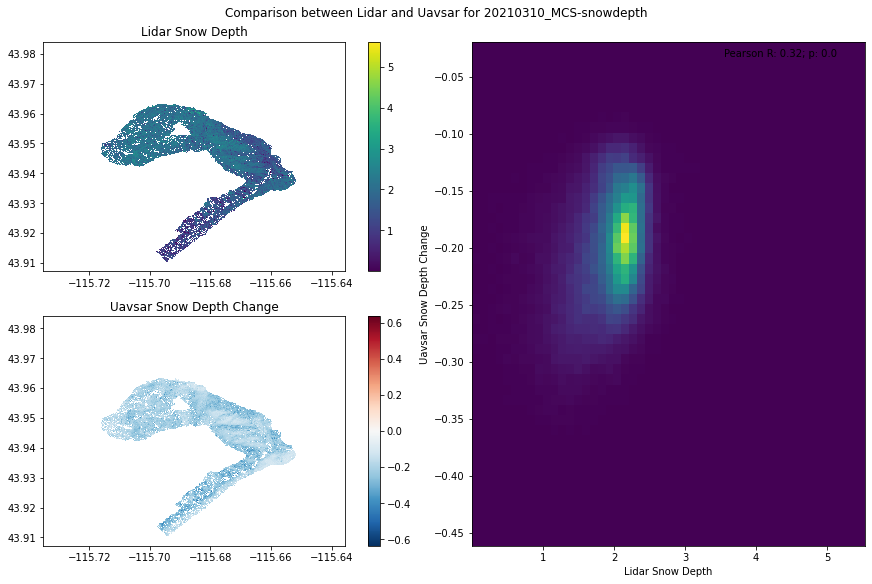

dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


slope: 0.08127782271874698. intercept: 0.041440165847432736. r_value 0.5768162263826494. p value: 0.0


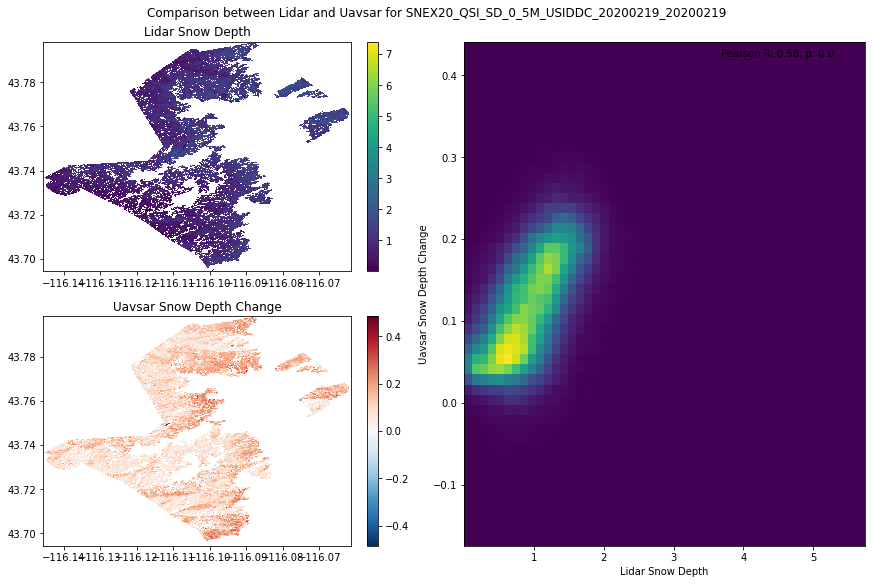

banner
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/banner/SNEX20_QSI_SD_0.5M_USIDBS_20200218_20200219.tif
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


slope: 0.03213099504827939. intercept: -0.03781563686500722. r_value 0.261051315614606. p value: 0.0


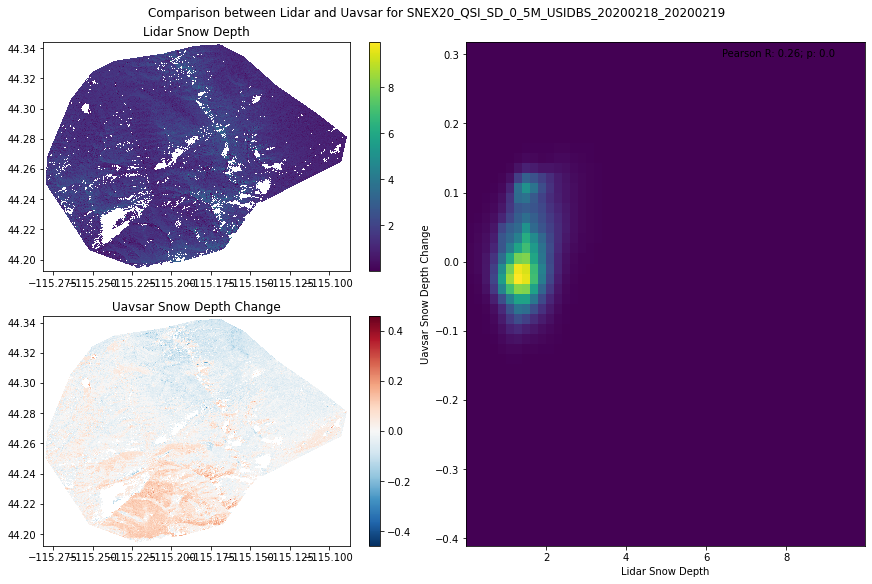

banner
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/banner/SNEX20_QSI_SD_0.5M_USIDBS_20210315_20210315.tif
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


slope: 0.00159846941529708. intercept: -0.11843104179105796. r_value 0.02396411861544529. p value: 1.4002371753534602e-213


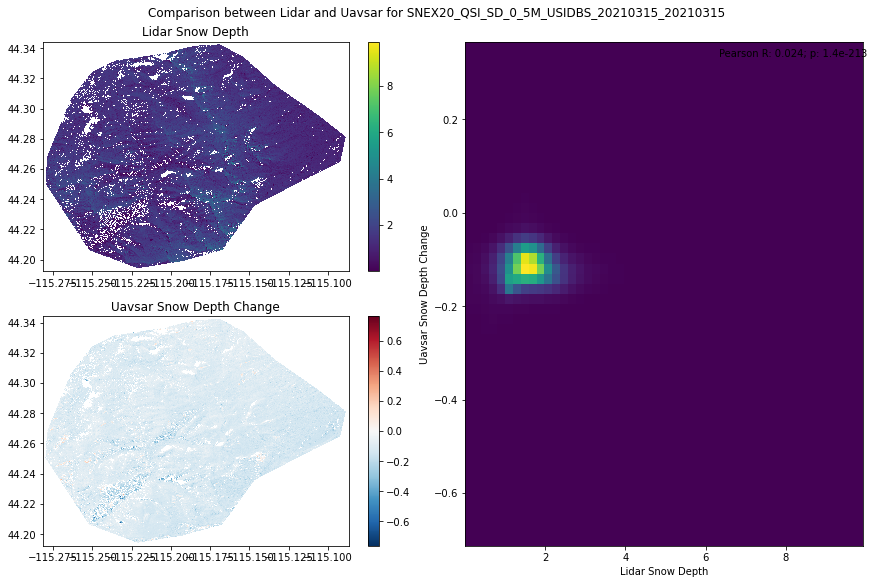

In [171]:
low_vv_imgs = [fps for fps in image_fps if (fps['location'] == 'Lowman, CO') & (fps['pol'] == 'VV')]
for loc_dir in glob(join(lidar_dir , 'Lowman,_CO', '*')):
    sd_fps = glob(join(loc_dir, '*_SD_*')) + glob(join(loc_dir, '*snowdepth*'))
    for sd_fp in sd_fps:
        # if sd_fp == '/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif':
            print(basename(loc_dir))
            print(sd_fp)
            sd = rxa.open_rasterio(sd_fp).rio.reproject('EPSG:4326')
            lidar_date = pd.Timestamp(get_name(sd_fp).date()).tz_localize('US/MOUNTAIN')
            imgs = [im for im in low_vv_imgs if (im['flight1'] < lidar_date) & (im['flight2'] > lidar_date)]
            save = True
            if len(imgs) == 1:
                img = imgs[0]
            elif len(imgs) > 1:
                img = imgs[1]
            elif len(imgs) == 0:
                td = pd.Timedelta('1 day')
                while len(imgs) == 0:
                    imgs = [im for im in low_vv_imgs if (im['flight1'] - td < lidar_date) & (im['flight2'] + td > lidar_date)]
                    td += pd.Timedelta('1 day')
                img = imgs[0]
            phase = rxa.open_rasterio(img['fp'])
            phase = phase.rio.clip_box(*sd.rio.bounds())
            inc = rxa.open_rasterio(img['inc'])
            inc = inc.rio.reproject_match(phase)
            cor = rxa.open_rasterio(img['cor'])
            cor = cor.rio.reproject_match(phase)
            sd_delta = get_snow_depth_change(basename(loc_dir),img['flight1'],img['flight2'])
            loc = get_snotel_loc(basename(loc_dir))
            snotel_inc = inc.sel(x = loc.x, y = loc.y, method = 'nearest').values[0]
            phase_correct = phase_from_depth(sd_delta, inc_angle= snotel_inc, density = 250)
            snotel_phase = phase.sel(x= loc.x, y=loc.y, method = 'nearest').values[0]
            if np.isnan(snotel_phase):
                snotel_phase = 0
            uavsar_sd = depth_from_phase(phase.values - (snotel_phase - phase_correct), inc.values, density = 250)
            phase.values = uavsar_sd

            sd = sd.rio.reproject_match(phase)
            sd = sd.where(sd < 10)
            sd = sd.where(sd > 0)
            # phase = phase.where(phase < )


            gs_kw = dict(width_ratios=[1, 1.3], height_ratios=[1, 1])
            fig, axes = plt.subplot_mosaic([['upper left', 'right'],
                    ['lower left', 'right']],
                    figsize=(12, 8), layout="constrained", gridspec_kw=gs_kw)
            sd = sd.where(sd < 1000)
            sd.where(~np.isnan(phase)).plot(ax = axes['upper left'])
            axes['upper left'].set_title('Lidar Snow Depth')
            phase.where(~np.isnan(sd)).plot(ax = axes['lower left'])
            axes['lower left'].set_title('Uavsar Snow Depth Change')
            for ax in ['upper left', 'lower left']:
                axes[ax].set_xlabel('')
                axes[ax].set_ylabel('')


            sds, uav, cors = clean_nps([sd.values.ravel(), phase.values.ravel(), cor.values.ravel()])
            cond = (cors > 0.6)
            slope, intercept,r,p, _, _ = r2_value(sds[cond], uav[cond])
            axes['right'].hist2d(sds[cond], uav[cond], bins = 50)
            axes['right'].annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [0.64,0.97], xycoords = 'axes fraction')
            axes['right'].set_xlabel('Lidar Snow Depth')
            axes['right'].set_ylabel('Uavsar Snow Depth Change')
            name = '_'.join(basename(sd_fp).split('.')[:-1])
            fig.suptitle(f'Comparison between Lidar and Uavsar for {name}')
            if save:
                plt.savefig(join(fig_dir, basename(sd_fp)))
            plt.show()
            

mores
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/mores/SNEX20_QSI_SD_0.5M_USIDMC_20200209_20200209.tif
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


slope: 0.03735223355093015. intercept: 0.04453397330084141. r_value 0.2352786209291669. p value: 7.056263014065971e-144


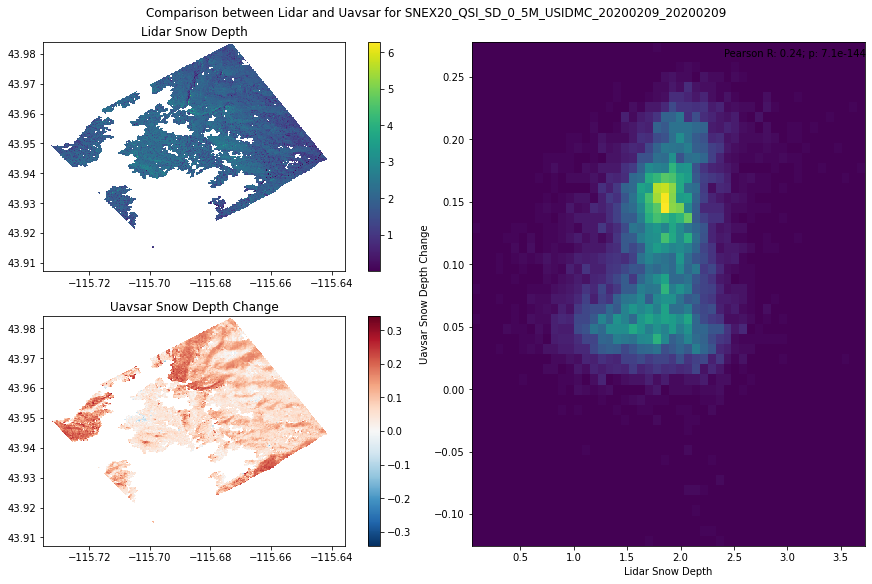

mores
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/mores/SNEX20_QSI_SD_0.5M_USIDMC_20210315_20210315.tif
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


slope: 0.009838933477527968. intercept: -0.15979431521710807. r_value 0.1476256302604958. p value: 3.4367444649635555e-128


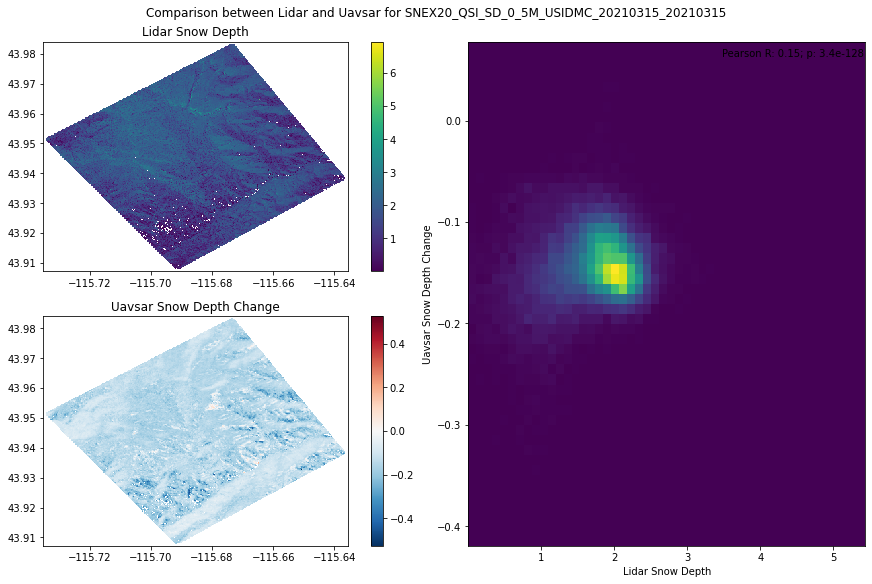

mores
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/mores/20210310_MCS-snowdepth.tif
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


slope: 0.03597254765355786. intercept: -0.2602834870168649. r_value 0.34721488416412. p value: 6.446963759380646e-186


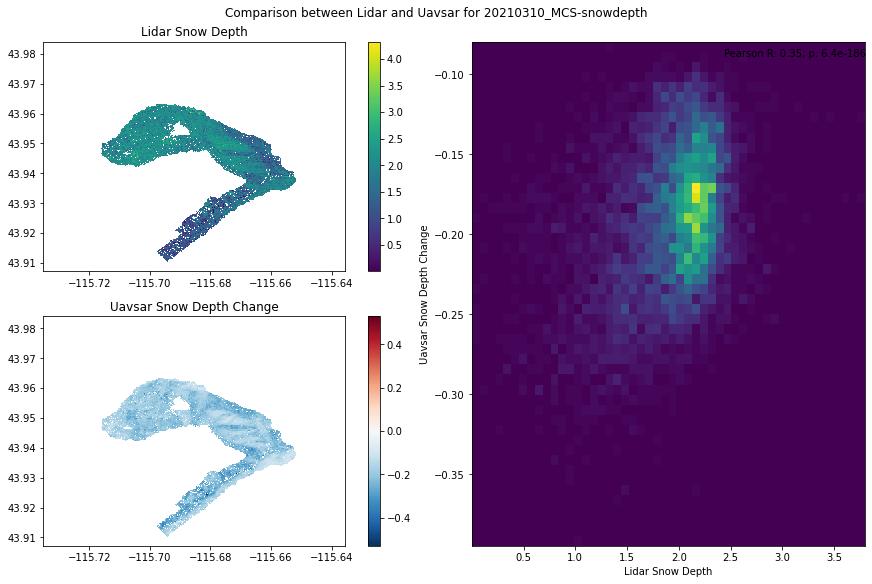

dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


slope: 0.07645098502500276. intercept: 0.043615392676976755. r_value 0.5778578405811698. p value: 0.0


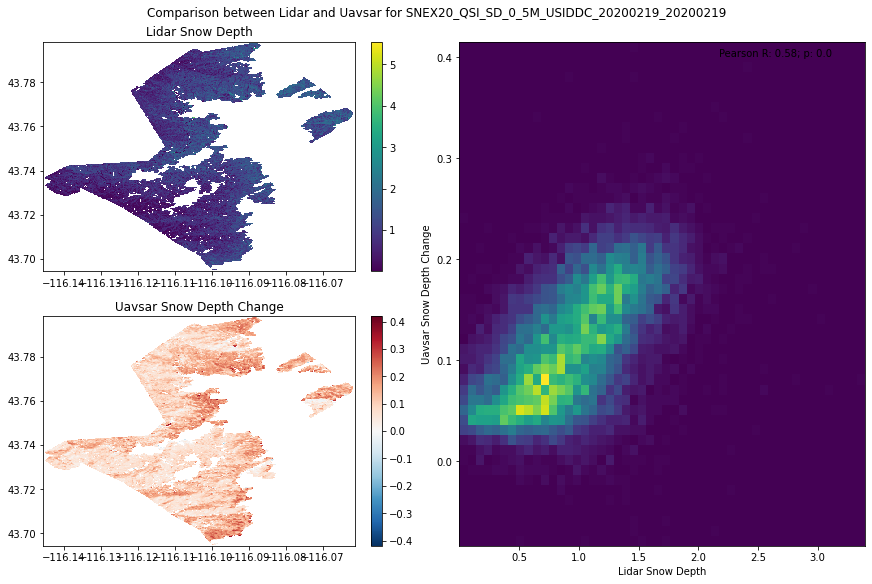

banner
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/banner/SNEX20_QSI_SD_0.5M_USIDBS_20200218_20200219.tif
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


slope: 0.03121510063126142. intercept: -0.030651454071081427. r_value 0.26149067213153454. p value: 0.0


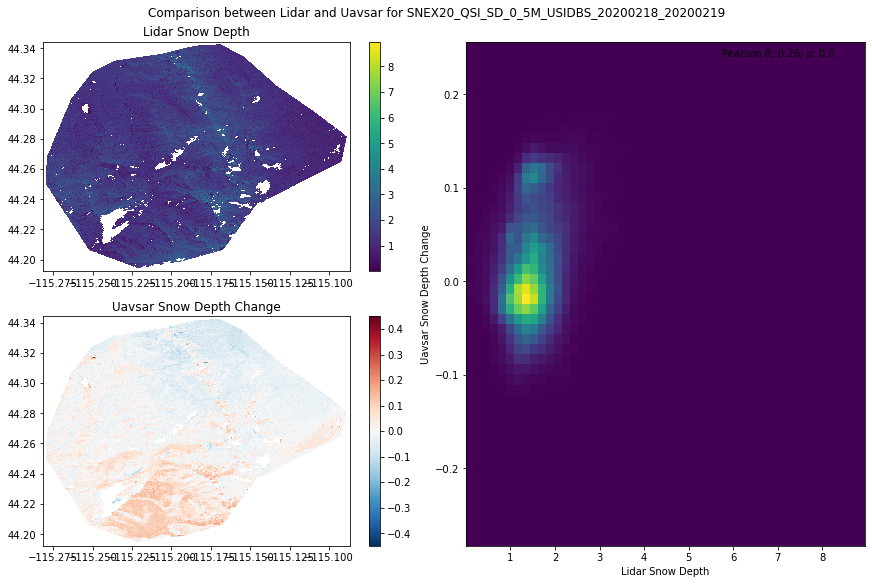

banner
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/banner/SNEX20_QSI_SD_0.5M_USIDBS_20210315_20210315.tif
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


slope: 0.0025823730366012075. intercept: -0.1399859496107517. r_value 0.03893257765663052. p value: 8.687115011949301e-38


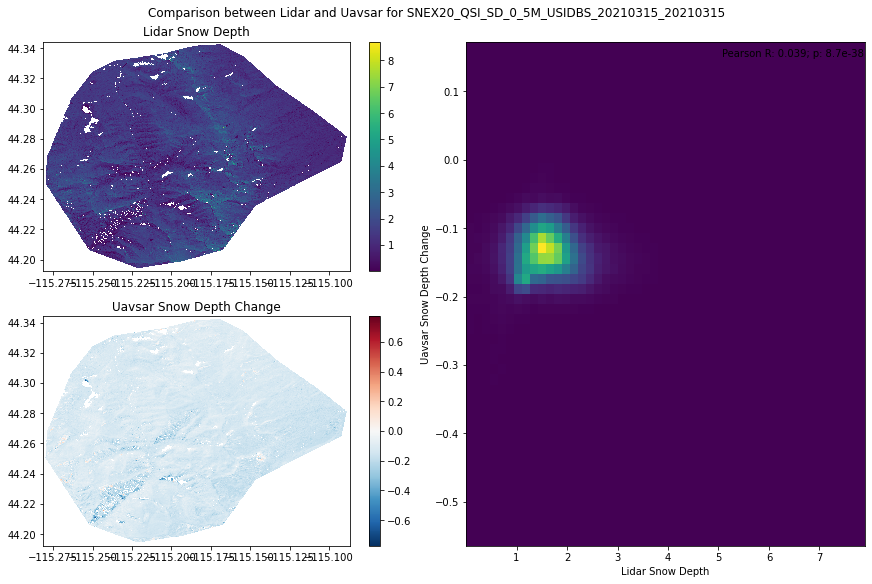

In [172]:
from rasterio.enums import Resampling

low_vv_imgs = [fps for fps in image_fps if (fps['location'] == 'Lowman, CO') & (fps['pol'] == 'VV')]
for loc_dir in glob(join(lidar_dir , 'Lowman,_CO', '*')):
    sd_fps = glob(join(loc_dir, '*_SD_*')) + glob(join(loc_dir, '*snowdepth*'))
    for sd_fp in sd_fps:
        # if sd_fp == '/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/banner/SNEX20_QSI_SD_0.5M_USIDBS_20200218_20200219.tif':
            print(basename(loc_dir))
            print(sd_fp)
            sd = rxa.open_rasterio(sd_fp).rio.reproject('EPSG:4326')
            lidar_date = pd.Timestamp(get_name(sd_fp).date()).tz_localize('US/MOUNTAIN')
            imgs = [im for im in low_vv_imgs if (im['flight1'] < lidar_date) & (im['flight2'] > lidar_date)]
            if len(imgs) == 1:
                img = imgs[0]
            elif len(imgs) > 1:
                img = imgs[1]
                save = True
            elif len(imgs) == 0:
                td = pd.Timedelta('1 day')
                while len(imgs) == 0:
                    imgs = [im for im in low_vv_imgs if (im['flight1'] - td < lidar_date) & (im['flight2'] + td > lidar_date)]
                    td += pd.Timedelta('1 day')
                img = imgs[0]
            phase = rxa.open_rasterio(img['fp'])
            phase = phase.rio.clip_box(*sd.rio.bounds())

            desc = pd.read_csv(img['ann'])
                # calculate how to get to 30 metere resolution from 0.0005 degrees
            new_res_m = 30
            y1 = float(desc['grd.row_addr'][0])
            dy = float(desc['grd.row_mult'][0])
            x1 = float(desc['grd.col_addr'][0])
            dx = float(desc['grd.col_mult'][0])
            conversion = (new_res_m/1000) / calc_distance(y1, x1, y1+dy, x1 + dx)
            phase = phase.rio.reproject(phase.rio.crs, \
                                            shape = (int(phase.rio.height/conversion), int(phase.rio.width/conversion)),
                                            resampling = Resampling.average)

            inc = rxa.open_rasterio(img['inc'])
            inc = inc.rio.reproject_match(phase)
            cor = rxa.open_rasterio(img['cor'])
            cor = cor.rio.reproject_match(phase)
            sd_delta = get_snow_depth_change(basename(loc_dir),img['flight1'],img['flight2'])
            loc = get_snotel_loc(basename(loc_dir))
            snotel_inc = inc.sel(x = loc.x, y = loc.y, method = 'nearest').values[0]
            phase_correct = phase_from_depth(sd_delta, inc_angle= snotel_inc, density = 250)
            snotel_phase = phase.sel(x= loc.x, y=loc.y, method = 'nearest').values[0]
            if np.isnan(snotel_phase):
                snotel_phase = 0
            uavsar_sd = depth_from_phase(phase.values - (snotel_phase - phase_correct), inc.values, density = 250)
            phase.values = uavsar_sd

            sd = sd.rio.reproject_match(phase)
            sd = sd.where(sd < 10)
            sd = sd.where(sd > 0)

            gs_kw = dict(width_ratios=[1, 1.3], height_ratios=[1, 1])
            fig, axes = plt.subplot_mosaic([['upper left', 'right'],
                    ['lower left', 'right']],
                    figsize=(12, 8), layout="constrained", gridspec_kw=gs_kw)
            sd = sd.where(sd < 1000)
            sd.where(~np.isnan(phase)).plot(ax = axes['upper left'])
            axes['upper left'].set_title('Lidar Snow Depth')
            phase.where(~np.isnan(sd)).plot(ax = axes['lower left'])
            axes['lower left'].set_title('Uavsar Snow Depth Change')
            for ax in ['upper left', 'lower left']:
                axes[ax].set_xlabel('')
                axes[ax].set_ylabel('')


            sds, uav, cors = clean_nps([sd.values.ravel(), phase.values.ravel(), cor.values.ravel()])
            cond = (cors > 0.6)
            slope, intercept,r,p, _, _ = r2_value(sds[cond], uav[cond])
            axes['right'].hist2d(sds[cond], uav[cond], bins = 50)
            axes['right'].annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [0.64,0.97], xycoords = 'axes fraction')
            axes['right'].set_xlabel('Lidar Snow Depth')
            axes['right'].set_ylabel('Uavsar Snow Depth Change')
            name = '_'.join(basename(sd_fp).split('.')[:-1])
            fig.suptitle(f'Comparison between Lidar and Uavsar for {name}')
            plt.savefig(join(fig_dir, 're30m_'+basename(sd_fp)))
            plt.show()
            